In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
import cvxpy as cxv
sns.set_style('darkgrid')
sns.set_context('notebook')
import sys
sys.path.append('..')

In [188]:
from osd import Problem
from osd.components import GaussNoise, SmoothFirstDifference, SparseFirstDiffConvex, Boolean, MarkovChain, SmoothSecondDifference
from osd.utilities import progress
import cvxpy as cvx

In [4]:
from admm_helpers import markov_process_simulator, run_admm

In [5]:
def proj_l2_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(y) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(y)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d1(data, theta=1, c=1):
    """Sum of absolute value of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=1))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d2(data, theta=1, c=1):
    """Sum of absolute value of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=2))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d2(data, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=2)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d1(data, theta=1, c=1):
    """Sum of squares of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=1)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def make_data(length, points=None, shifts=None):
    if points is None:
        points = [0, int(length * 0.2), int(length * 0.55), int(length * 0.85), length]
    if shifts is None:
        shifts = [0, .5, -0.75, .2]
    cp = np.zeros(length)
    for ix, shft in enumerate(shifts):
        a = points[ix]
        b = points[ix + 1]
        cp[a:b] = shft
    return cp

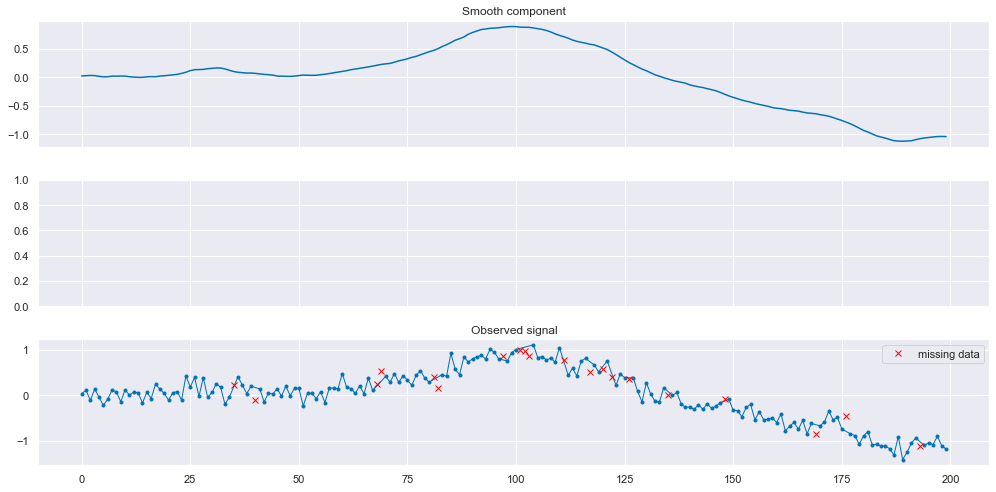

In [6]:
np.random.seed(4)
T = 200
X_real = np.zeros((2, T))
X_real[0] = 0.15 * np.random.randn(T)
X_real[1] = 5 * proj_l2_d1(np.random.randn(T), theta=3e2)
X_real[1] -= np.average(X_real[1])
# X_real[2] = markov_process_simulator([[0.9, 0.1], [0.1, 0.9]], T=T, plot=False)
y = np.sum(X_real, axis=0)
np.random.seed(25)
remove_ix = np.random.choice(np.arange(len(y)), int(len(y) * 0.1), replace=False)
remove_ix.sort()
use_ix = np.ones_like(y, dtype=bool)
use_ix[remove_ix] = False

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
# ax[1].set_title('boolean component')
# ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(np.arange(T)[use_ix], y[use_ix], linewidth=1, marker='.')
ax[2].plot(np.arange(T)[~use_ix], y[~use_ix], linewidth=1, marker='x', color='red', ls='none', label='missing data')
ax[2].legend()
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()


In [293]:
np.average(np.abs(np.random.randn(1000) * .15))

0.12404179734238249

IndexError: index 3 is out of bounds for axis 0 with size 3

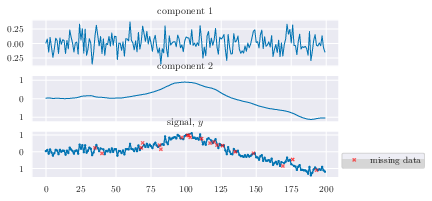

In [292]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75)
        ax[k].set_title('component {}'.format(k+1))
    else:
        ax[k].plot(np.arange(T)[use_ix], y[use_ix], linewidth=1, marker='.', ms=2)
        ax[k].plot(np.arange(T)[~use_ix], y[~use_ix], linewidth=1, marker='x', ms=3,
                   color='red', ls='none', label='missing data', alpha=0.6)
        ax[k].set_title('signal, $y$')
        ax[k].legend(loc=(1.01, 0.2))
        
ax[1].set_ylim(-1.25, 1.25)
ax[3].set_ylim(-2, 2)
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/example-components.pgf')
plt.show()

In [248]:
lmbdas = np.logspace(-1, 1, 10)

In [260]:
lambda2 = 10
c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=lambda2)
components = [c1, c2]
problem = Problem(y, components)

In [258]:
problem.decompose(solver='MOSEK')

In [279]:
problem.decompose(admm=True, rho=1, num_iter=100, stop_early=False)#, use_set=use_ix)

sos = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
sae = np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~use_ix]))
print('sos: {:.2f}, sae: {:.2f}'.format(sos, sae))

[============================================================] 100.0% ...0.15 sec
sos: 0.00, sae: 0.00


In [280]:
import matplotlib
sns.set_context('paper')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

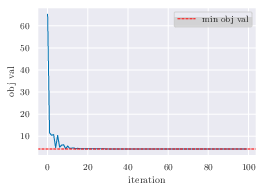

In [296]:
plt.figure(figsize=(3.75,2.75))
plt.plot((problem.admm_result['obj_vals']), linewidth=0.75)
plt.axhline((problem.admm_result['best_obj']), color='red', ls='--', label='min obj val', linewidth=0.75)
# plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('obj val')
# plt.title('ADMM convergence,\nconvex problem')
plt.legend()
fig = plt.gcf()
fig.tight_layout()
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/converge-convex.pgf')

In [253]:
# ylim = (-0.65, 1.2)

Text(0.5, 1.0, 'holdout errors')

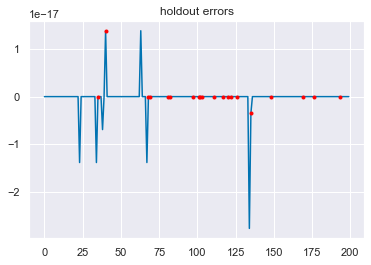

In [254]:
plt.plot((y - np.sum(problem.estimates, axis=0)))
plt.plot(np.arange(len(y))[~use_ix], (y - np.sum(problem.estimates, axis=0))[~use_ix], color='red', marker='.', ls='none')
plt.title('holdout errors')
# plt.ylim(*ylim)

In [255]:
# import matplotlib
# sns.set_context('paper')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })


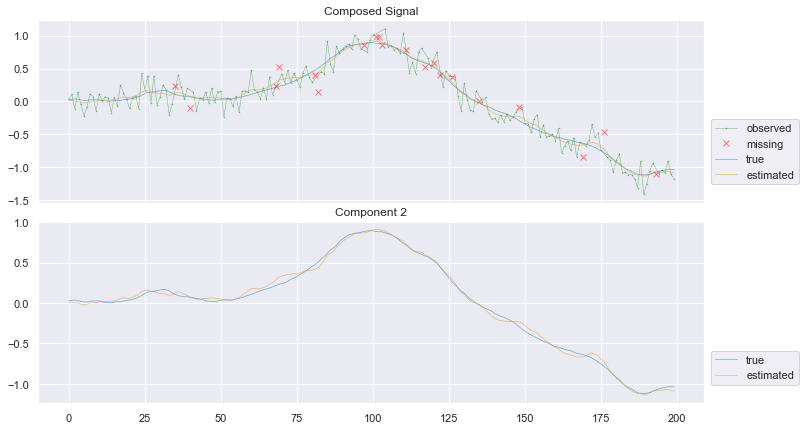

In [259]:
K = len(components)
fs = np.array([5.5,2.9])
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=2*fs)
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(est, label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Component {}'.format(k+1))
    else:
        ax[k].plot(
            np.arange(T)[use_ix],
            np.sum(X_real, axis=0)[use_ix], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5
        )
        ax[k].plot(
            np.arange(T)[~use_ix],
            np.sum(X_real, axis=0)[~use_ix], 
            label='missing', marker='x', color='red', ls='none', alpha=0.5
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Composed Signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

In [21]:
~np.all(np.isclose(np.diff(problem.estimates[-1]), 0))

False

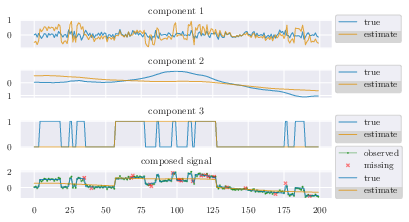

In [652]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75, label='true', alpha=0.75)
        ax[k].plot(problem.estimates[k], label='estimate', linewidth=0.75, alpha=0.75)
        ax[k].set_title('component {}'.format(k+1))
        ax[k].legend(loc=[1.01, 0.2])
    else:
        ax[k].plot(
            np.arange(T)[use_ix],
            np.sum(X_real, axis=0)[use_ix], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1.5, alpha=0.5
        )
        ax[k].plot(
            np.arange(T)[~use_ix],
            np.sum(X_real, axis=0)[~use_ix], 
            label='missing', marker='x', color='red', ls='none', alpha=0.5, ms=3
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.75)
        ax[k].plot(problem.estimates[1] + problem.estimates[2], label='estimate', 
                   linewidth=0.75, alpha=0.75)
        ax[k].set_title('composed signal')
        ax[k].legend(loc=[1.01, 0.0])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example-bad.pgf')

Using a single test set (20% reserved), wide search, fine grid. Set to run before went to bed

In [147]:
# l2s = np.logspace(-0.5,3.5,60)
# l3s = np.logspace(-1.5,1.5,60)
# errors = np.zeros((len(l3s), len(l2s)))
# count_switches = np.zeros((len(l3s), len(l2s)))
# smoothness = np.zeros((len(l3s), len(l2s)))
# counter = 0
# for j, l2 in enumerate(l2s):
#     for i, l3 in enumerate(l3s):
#         progress(counter, errors.size)
#         c1 = GaussNoise()
#         c2 = SmoothFirstDifference(theta=l2)
#         p = 0.25
#         c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=l3)
#         components = [c1, c2, c3]
#         problem = Problem(y, components)
#         problem.decompose(admm=True, rho=1, num_iter=100, use_set=use_ix, verbose=False)
#         error = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
#         errors[i, j] = error
#         smoothness[i, j] = np.sum(np.power(np.diff(problem.estimates[1]), 2))
#         count_switches[i, j] = np.sum(~np.isclose(np.diff(problem.estimates[-1]), 0))
#         counter += 1
# progress(counter, errors.size)
# run1 = {
#     'l2': np.copy(l2s),
#     'l3': np.copy(l3s),
#     'error': np.copy(errors),
#     'smoothness': np.copy(smoothness),
#     'switches': np.copy(count_switches)
# }
# with open('validation_run_1.pkl', 'wb') as f:
#     pickle.dump(run1, f)

In [472]:
with open('validation_run_1.pkl', 'rb') as f:
    run1 = pickle.load(f)

In [497]:
f2 = interp1d(run1['l2'], np.arange(len(run1['l2'])))
f3 = interp1d(run1['l3'], np.arange(len(run1['l3'])))
xticks = [f2(i).item() for i in np.logspace(0, 3, 4)]
yticks = [f3(i).item() for i in np.logspace(-1, 1, 3)]
xticklabels = ['$10^{'+'{}'.format(i)+'}$' for i in range(len(xticks))]
yticklabels = ['$10^{'+'{}'.format(i - 1)+'}$' for i in range(len(yticks))]

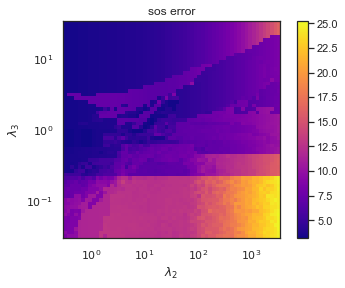

<Figure size 432x288 with 0 Axes>

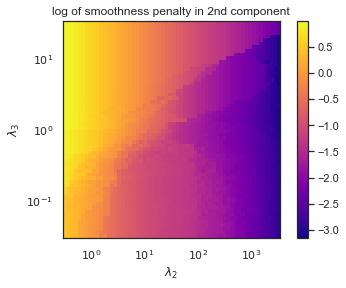

<Figure size 432x288 with 0 Axes>

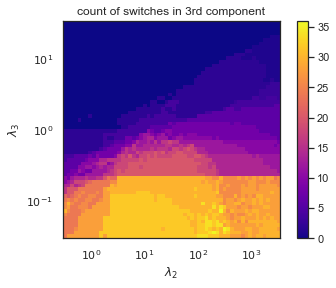

In [498]:
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1)
    cp = ax.imshow(run1['error'], cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sos error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1)
    cp = ax.imshow(np.log10(run1['smoothness']), cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('log of smoothness penalty in 2nd component');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1)
    cp = ax.imshow(run1['switches'], cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('count of switches in 3rd component');

In [169]:
from sklearn.model_selection import KFold

Tighten upper and lower bounds a bit, and use Stephens bootstrap resampling strategy. Caution, this takes all afternoon to execute.

In [402]:
# l2s = np.logspace(0,3,20)
# l3s = np.logspace(-1,0.5,20)
# num_splits = 20
# hold = 0.2
# splits = []
# for s in range(num_splits):
#     remove_ix = np.random.choice(np.arange(len(y)), int(len(y) * hold), replace=False)
#     remove_ix.sort()
#     use_ix = np.ones_like(y, dtype=bool)
#     use_ix[remove_ix] = False
#     splits.append(use_ix)

# l2_errors = np.zeros((len(l3s), len(l2s)))
# l1_errors = np.zeros((len(l3s), len(l2s)))
# count_switches = np.zeros((len(l3s), len(l2s)))
# smoothness = np.zeros((len(l3s), len(l2s)))
# counter = 0
# for j, l2 in enumerate(l2s):
#     for i, l3 in enumerate(l3s):
#         progress(counter, errors.size)
#         c1 = GaussNoise()
#         c2 = SmoothFirstDifference(theta=l2)
#         p = 0.25
#         c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=l3)
#         components = [c1, c2, c3]
#         problem = Problem(y, components)
#         sos = 0
#         sae = 0
#         smth = 0
#         count_sw = 0
#         for uix in splits:
#                 problem.decompose(admm=True, rho=1, num_iter=100, use_set=uix, verbose=False)
# #                 print(np.sum(np.power((y - np.sum(problem.estimates, axis=0))[test_ix], 2)))
#                 sos += np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~uix], 2))
#                 sae += np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~uix]))
#                 smth =+ np.sum(np.power(np.diff(problem.estimates[1]), 2))
#                 count_sw +=np.sum(~np.isclose(np.diff(problem.estimates[-1]), 0))
#         l2_errors[i, j] = sos / (num_splits * np.sum(~uix))
#         l1_errors[i, j] = sae / (num_splits * np.sum(~uix))
#         smoothness[i, j] = smth / (num_splits)
#         count_switches[i, j] = count_sw / (num_splits)
#         counter += 1
# progress(counter, errors.size)
# run2 = {
#     'l2': np.copy(l2s),
#     'l3': np.copy(l3s),
#     'sos': np.copy(l2_errors),
#     'sae': np.copy(l1_errors),
#     'smoothness': np.copy(smoothness),
#     'switches': np.copy(count_switches)
# }
# with open('validation_run_2.pkl', 'wb') as f:
#     pickle.dump(run2, f)

In [474]:
with open('validation_run_2.pkl', 'rb') as f:
    run2 = pickle.load(f)

In [443]:
from scipy.interpolate import interp1d

In [504]:
f2 = interp1d(run2['l2'], np.arange(len(run2['l2'])))
f3 = interp1d(run2['l3'], np.arange(len(run2['l3'])))
xticks = [f2(i).item() for i in np.logspace(0, 3, 4)]
yticks = [f3(i).item() for i in np.logspace(-1, 0, 2)]
xticklabels = ['$10^{'+'{}'.format(i)+'}$' for i in range(len(xticks))]
yticklabels = ['$10^{'+'{}'.format(i - 1)+'}$' for i in range(len(yticks))]

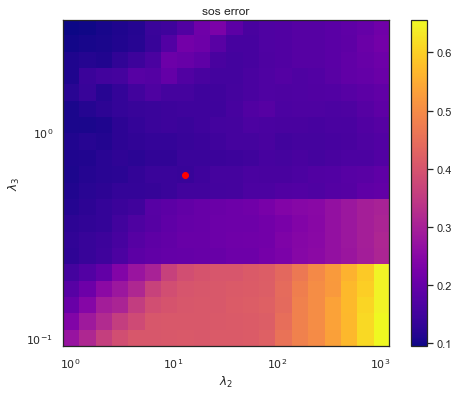

<Figure size 432x288 with 0 Axes>

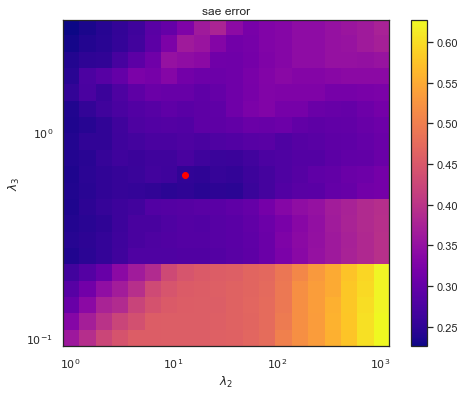

<Figure size 432x288 with 0 Axes>

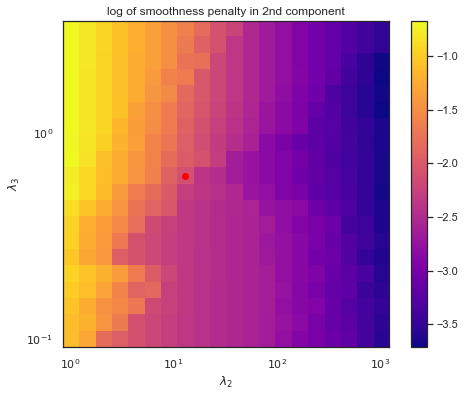

<Figure size 432x288 with 0 Axes>

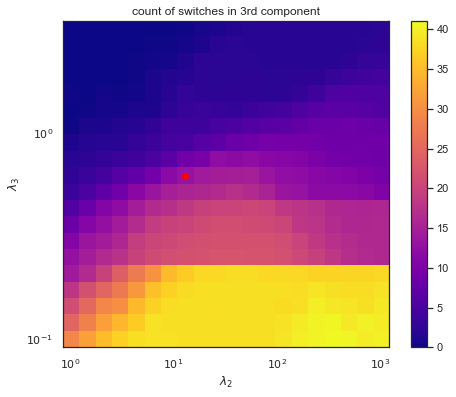

In [516]:
i = 10
j = 7
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run2['sos'], cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sos error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run2['sae'], cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sae error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(np.log10(run2['smoothness']), cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('log of smoothness penalty in 2nd component');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run2['switches'], cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('count of switches in 3rd component');

IndexError: index 10 is out of bounds for axis 0 with size 10

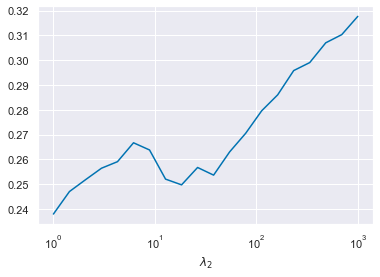

In [567]:
i = 10
j = 7
X, Y = np.meshgrid(run2['l2'], run2['l3'])
plt.plot(X[i], run2['sae'][i])
plt.xscale('log')
plt.xlabel('$\lambda_2$')
plt.title('error for $\lambda_3={:.2e}$'.format(l3s[i]))
plt.axvline(l2s[j], color='red', ls='--')
plt.figure()
plt.plot(Y[:, j], run2['sae'][:, j])
plt.xscale('log')
plt.xlabel('$\lambda_3$')
plt.axvline(l3s[i], color='red', ls='--')
plt.title('error for $\lambda_2={:.2e}$'.format(l2s[j]))

In [493]:
lambda2 = l2s[j] * .75
lambda3 = l3s[i]
c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=lambda2)
p = 0.25
c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=lambda3)
components = [c1, c2, c3]

problem = Problem(y, components)
problem.decompose(admm=True, rho=1, num_iter=100)#, use_set=use_ix)
sos = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
sae = np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~use_ix]))
print('sos: {:.2f}, sae: {:.2f}'.format(sos, sae))

[============================================================] 100.0% ...1.44 sec
sos: 0.00, sae: 0.00


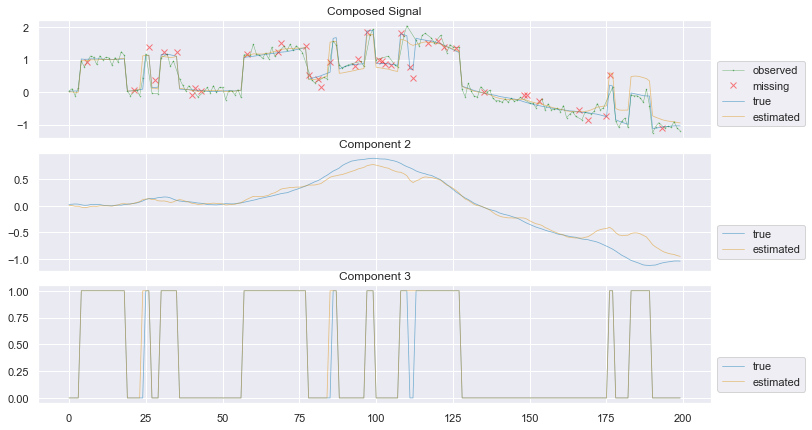

In [494]:
K = len(components)
fs = np.array([5.5,2.9])
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=2*fs)
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(est, label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Component {}'.format(k+1))
    else:
        ax[k].plot(
            np.arange(T)[use_ix],
            np.sum(X_real, axis=0)[use_ix], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5
        )
        ax[k].plot(
            np.arange(T)[~use_ix],
            np.sum(X_real, axis=0)[~use_ix], 
            label='missing', marker='x', color='red', ls='none', alpha=0.5
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Composed Signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

Okay, narrow the search space even more, and don't go overkill on the number of bootstraps :/

this is "run 4". "run 3" is in the other notebook and has a higher switching rate

In [524]:
np.logspace(np.log10(0.2), np.log10(2), 10)

array([0.2       , 0.25830993, 0.33362011, 0.43088694, 0.55651188,
       0.71876273, 0.92831777, 1.1989685 , 1.54852737, 2.        ])

In [568]:
# l2s = np.logspace(0, 2, 10)
# l3s = np.logspace(-1, 1, 10)
# num_splits = 12
# hold = 0.1
# splits = []
# for s in range(num_splits):
#     remove_ix = np.random.choice(np.arange(len(y)), int(len(y) * hold), replace=False)
#     remove_ix.sort()
#     use_ix = np.ones_like(y, dtype=bool)
#     use_ix[remove_ix] = False
#     splits.append(use_ix)

# l2_errors = np.zeros((len(l3s), len(l2s)))
# l1_errors = np.zeros((len(l3s), len(l2s)))
# count_switches = np.zeros((len(l3s), len(l2s)))
# smoothness = np.zeros((len(l3s), len(l2s)))
# counter = 0
# for j, l2 in enumerate(l2s):
#     for i, l3 in enumerate(l3s):
#         progress(counter, l2_errors.size)
#         c1 = GaussNoise()
#         c2 = SmoothFirstDifference(theta=l2)
#         p = 0.25
#         c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=l3)
#         components = [c1, c2, c3]
#         problem = Problem(y, components)
#         sos = 0
#         sae = 0
#         smth = 0
#         count_sw = 0
#         for uix in splits:
#                 problem.decompose(admm=True, rho=1, num_iter=100, use_set=uix, verbose=False)
# #                 print(np.sum(np.power((y - np.sum(problem.estimates, axis=0))[test_ix], 2)))
#                 sos += np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~uix], 2))
#                 sae += np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~uix]))
#                 smth =+ np.sum(np.power(np.diff(problem.estimates[1]), 2))
#                 count_sw +=np.sum(~np.isclose(np.diff(problem.estimates[-1]), 0))
#         l2_errors[i, j] = sos / (num_splits * np.sum(~uix))
#         l1_errors[i, j] = sae / (num_splits * np.sum(~uix))
#         smoothness[i, j] = smth / (num_splits)
#         count_switches[i, j] = count_sw / (num_splits)
#         counter += 1
# progress(counter, l2_errors.size)
# run4 = {
#     'l2': np.copy(l2s),
#     'l3': np.copy(l3s),
#     'sos': np.copy(l2_errors),
#     'sae': np.copy(l1_errors),
#     'smoothness': np.copy(smoothness),
#     'switches': np.copy(count_switches)
# }
# with open('validation_run_4.pkl', 'wb') as f:
#     pickle.dump(run4, f)

In [587]:
with open('validation_run_4.pkl', 'rb') as f:
    run4 = pickle.load(f)

In [653]:
f2 = interp1d(run4['l2'], np.arange(len(run4['l2'])))
f3 = interp1d(run4['l3'], np.arange(len(run4['l3'])))
xticks = [f2(i).item() for i in np.logspace(0, 2, 3)]
yticks = [f3(i).item() for i in np.logspace(-1, 1, 3)]
xticklabels = ['$10^{'+'{}'.format(i)+'}$' for i in range(len(xticks))]
# yticklabels = [.5, 1]
yticklabels = ['$10^{'+'{}'.format(i - 1)+'}$' for i in range(len(yticks))]

In [654]:
run2['sos'].shape

(20, 20)

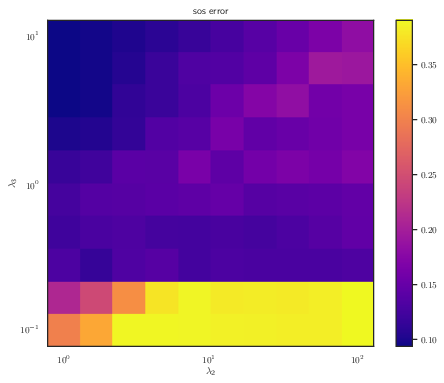

<Figure size 432x288 with 0 Axes>

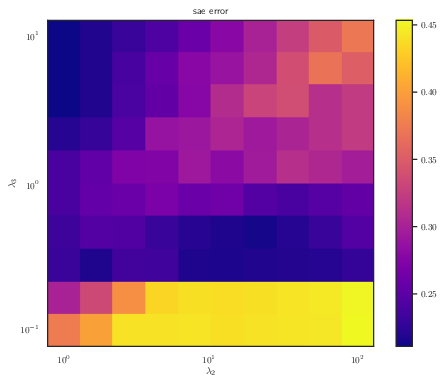

<Figure size 432x288 with 0 Axes>

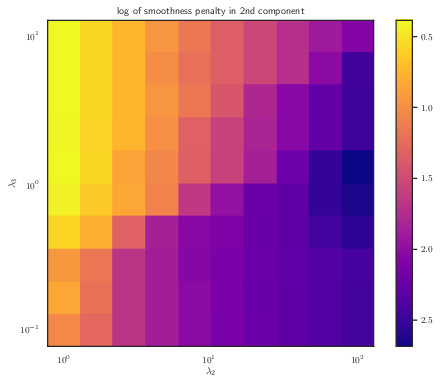

<Figure size 432x288 with 0 Axes>

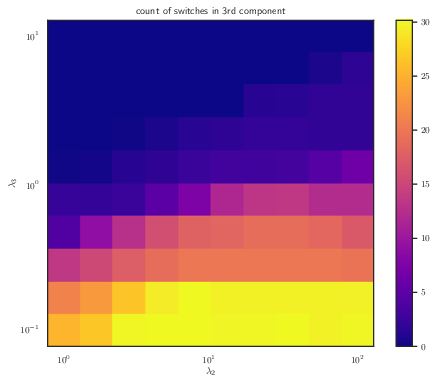

In [655]:
i = 10
j = 7
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run4['sos'], cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sos error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run4['sae'], cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sae error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(np.log10(run4['smoothness']), cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('log of smoothness penalty in 2nd component');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run4['switches'], cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('count of switches in 3rd component');

In [656]:
X, Y = np.meshgrid(run4['l2'], run4['l3'])
msk = run4['switches'] >= 1
i_best = np.argmin(run4['sae'][msk])
print(
    X[msk][i_best],
    Y[msk][i_best],
    run4['sae'][msk][i_best]
)

21.544346900318832 0.46415888336127786 0.2146939660221758


In [657]:
import matplotlib
sns.set_context('paper')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


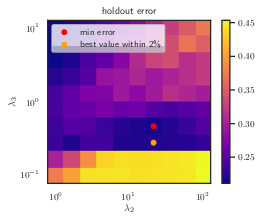

In [658]:
slct = run4['sae'] <= run4['sae'].ravel()[i_best]*1.02
best_lambda2 = np.max(X[slct])
best_lambda3 = np.min(Y[slct])
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(4,3))
    im = np.copy(run4['sae'])
#     im[~msk] = np.nan
    cp = ax.imshow(im, cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(X.ravel()[i_best]), f3( Y.ravel()[i_best]), color='red', label='min error')
    ax.scatter(f2(best_lambda2), f3(best_lambda3), color='orange', label='best value within 2%')
    ax.legend(loc=2)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('holdout error');
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/holdout-heatmap.pgf')

In [614]:
X, Y = np.meshgrid(run4['l2'], run4['l3'])
msk = run4['switches'] >= 1
i_best = np.argmin(run4['sos'][msk])
print(
    X[msk][i_best],
    Y[msk][i_best],
    run4['sos'][msk][i_best]
)

1.6681005372000588 0.2782559402207124 0.11599456123444814


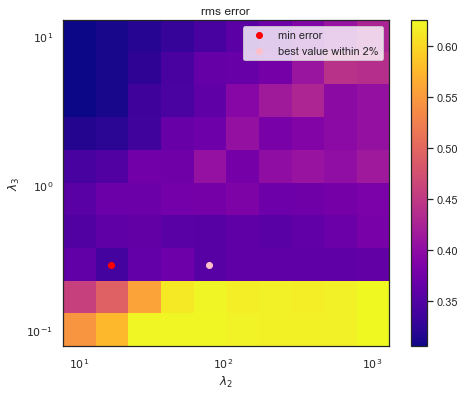

In [615]:
slct = run4['sos'] <= run4['sos'].ravel()[i_best]*1.025
best_lambda2 = np.max(X[slct])
best_lambda3 = np.min(Y[slct])
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    im = np.copy(run4['sos'])
#     im[~msk] = np.nan
    cp = ax.imshow(np.sqrt(im), cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(X.ravel()[i_best]), f3( Y.ravel()[i_best]), color='red', label='min error')
    ax.scatter(f2(best_lambda2), f3(best_lambda3), color='pink', label='best value within 2%')
    ax.legend()
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('rms error');

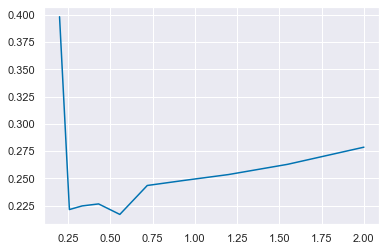

In [550]:
slct = np.isclose(X, 16.984992522418107)
plt.plot(Y[slct], run4['sae'][slct])
# plt.xscale('log')

<Figure size 432x288 with 0 Axes>

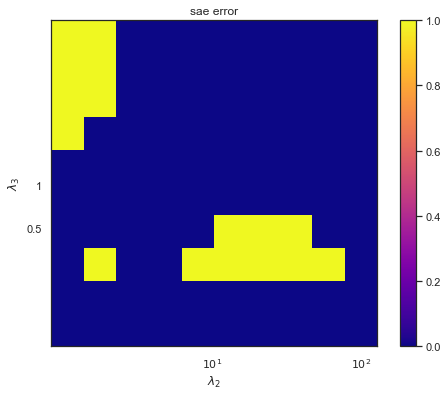

<Figure size 432x288 with 0 Axes>

In [579]:
slct = run4['sae'] <= run4['sae'].ravel()[i_best]*1.05
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(slct, cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(X[i_best]), f3(Y[i_best]), color='red')
#     ax.scatter(f2(X[i_best]), f3(Y[i_best]*0.5), color='pink')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sae error');
plt.figure()

In [560]:
np.max(X[slct])
np.min(Y[slct])

41.21285299808557

In [561]:
np.min(Y[slct])

0.25830993300297683

In [628]:
lambda2 = best_lambda2
lambda3 = best_lambda3
c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=lambda2)
p = 0.25
c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=lambda3)
components = [c1, c2, c3]

problem = Problem(y, components)
problem.decompose(admm=True, rho=1, num_iter=100)#, use_set=use_ix)
sos = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
sae = np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~use_ix]))
print('sos: {:.2f}, sae: {:.2f}'.format(sos, sae))

[============================================================] 100.0% ...1.54 sec
sos: 0.00, sae: 0.00


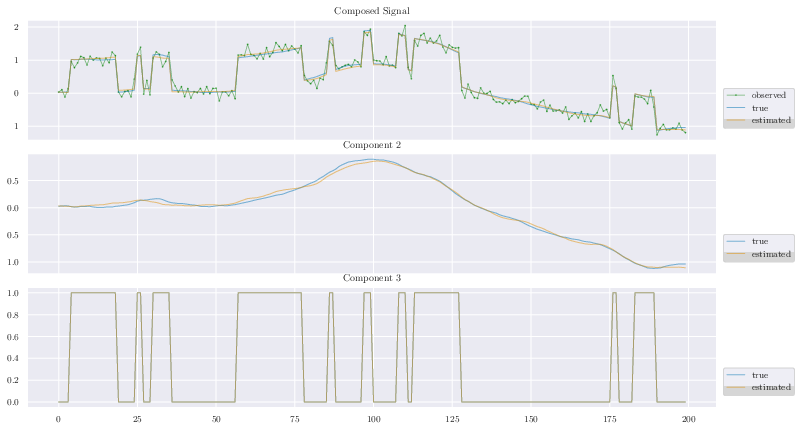

In [629]:
K = len(components)
fs = np.array([5.5,2.9])
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=2*fs)
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(est, label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Component {}'.format(k+1))
    else:
        ax[k].plot(
            np.arange(T)[:],
            np.sum(X_real, axis=0)[:], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5
        )
#         ax[k].plot(
#             np.arange(T)[~use_ix],
#             np.sum(X_real, axis=0)[~use_ix], 
#             label='missing', marker='x', color='red', ls='none', alpha=0.5
#         )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Composed Signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

In [634]:
print(lambda2, lambda3)

21.544346900318832 0.2782559402207124


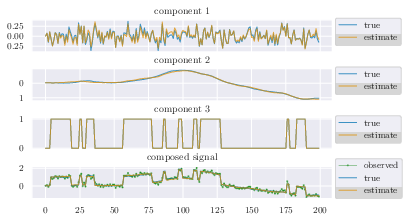

In [633]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75, label='true', alpha=0.75)
        ax[k].plot(problem.estimates[k], label='estimate', linewidth=0.75, alpha=0.75)
        ax[k].set_title('component {}'.format(k+1))
        ax[k].legend(loc=[1.01, 0.2])
    else:
        ax[k].plot(
            np.arange(T),
            np.sum(X_real, axis=0), 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1.5, alpha=0.5
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.75)
        ax[k].plot(problem.estimates[1] + problem.estimates[2], label='estimate', 
                   linewidth=0.75, alpha=0.75)
        ax[k].set_title('composed signal')
        ax[k].legend(loc=[1.01, 0.0])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example-final.pgf')